In [ ]:
!curl ifconfig.co
!curl ifconfig.co/country

34.90.247.110
Netherlands


In [ ]:
!pip install QuantLib-Python
# !pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch==?

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==? (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==?


In [ ]:
import QuantLib as ql 

maturity = ql.Date(31, 12, 2019)
S0 = 100
K = 100
r = 0.02
sigma = 0.20
d =  0.0
otype = ql.Option.Put
dc = ql.Actual365Fixed()
calendar = ql.NullCalendar()

today = ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = today

In [ ]:
payoff = ql.PlainVanillaPayoff(otype, K)

european_exercise = ql.EuropeanExercise(maturity)
european_option = ql.VanillaOption(payoff, european_exercise)

american_exercise = ql.AmericanExercise(today, maturity)
american_option = ql.VanillaOption(payoff, american_exercise)

In [ ]:
d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)

In [ ]:
pricing_dict = {}

bsm73 = ql.AnalyticEuropeanEngine(bsm_process)
european_option.setPricingEngine(bsm73)
pricing_dict['BlackScholesEuropean'] = european_option.NPV()

analytical_engine = ql.BaroneAdesiWhaleyApproximationEngine(bsm_process)
american_option.setPricingEngine(analytical_engine)
pricing_dict['BawApproximation'] = american_option.NPV()

binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
american_option.setPricingEngine(binomial_engine)
pricing_dict['BinomialTree'] = american_option.NPV()

# fd_engine = ql.FdBlackScholesVanillaEngine(bsm_process)
# american_option.setPricingEngine(fd_engine)
# pricing_dict['FiniteDifference'] = american_option.NPV()

print(pricing_dict)

{'BlackScholesEuropean': 6.92786901829998, 'BawApproximation': 7.091254636695334, 'BinomialTree': 7.090924645858217}


In [ ]:
import numpy as np
import gym
class AmeriOptionEnv(gym.Env):
    def __init__(self):
        self.S0 = 100.0
        self.K = 100.0
        self.r = 0.02
        self.sigma = 0.20
        self.T = 1.0
        self.N = 365    # 365 day

        self.S1 = 0
        self.reward = 0
        self.day_step = 0    # from day 0 taking N steps to day N

        self.action_space = gym.spaces.Discrete(2)         # 0: hold, 1:exercise
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, 1.0]), dtype=np.float32)      # S in [0, inf], tao in [0, 1]

    def step(self, action):
        if action == 1:        # exercise
            reward = max(K-self.S1, 0.0) * np.exp(-self.r * self.T * (self.day_step/self.N))
            done = True
        else:       # hold
            if self.day_step == self.N:    # at maturity
                reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T)
                done = True
            else: # move to tomorrow
                reward = 0
                # lnS1 - lnS0 = (r - 0.5*sigma^2)*t + sigma * Wt
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal())
                self.day_step += 1
                done = False

        tao = 1.0-self.day_step/self.N        # time to maturity, in unit of years
        return np.array([self.S1, tao]), reward, done, {}

    def reset(self):
        self.day_step = 0
        self.S1 = self.S0
        tao = 1.0-self.day_step/self.N        # time to maturity, in unit of years
        # return np.array([self.S1, tao], dtype='float32')
        return [self.S1, tao]

    
    def render(self):
        """
        make video
        """
        pass

    def close(self):
        pass

env_name = AmeriOptionEnv()

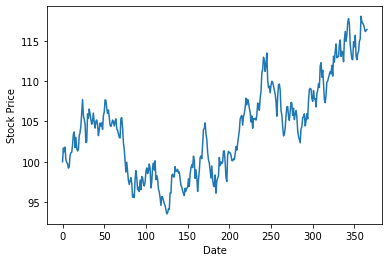

In [ ]:
import matplotlib.pyplot as plt

s = env_name.reset()

sim_prices = []
sim_prices.append(s[0])
for i in range(365):
  action = 0
  s_next, reward, done, info = env_name.step(action)
  sim_prices.append(s_next[0])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(sim_prices)

### Section Three -- Reinforcement Learning 
PyTorch to train a DQN agent [link](https://pytorch.org/docs/stable/torch.html)

In [ ]:
import gym
import copy 
import numpy as np
from collections import namedtuple
from itertools import count
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [ ]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(2, 128) # 2 because there are 2 parameters as the observation space
        self.actor = nn.Linear(128, 2) # 2 for the number of actions
        self.critic = nn.Linear(128, 1) # Critic is always 1
        self.saved_actions = []
        self.rewards = []
        self.action = 0
    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_prob = F.softmax(self.actor(x), dim=-1, dtype=torch.double)
        state_values = self.critic(x)
        return action_prob, state_values

In [ ]:
# Hyper-parameters
num_iterations = 1000 # @param {type:"integer"} # Takes a lot of time
learning_rate = 3e-1  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"} # print log after this many iterations


# initial_collect_steps = 100  # @param {type:"integer"}
# collect_steps_per_iteration =   1# @param {type:"integer"}
# replay_buffer_max_length = 100000  # @param {type:"integer"}
# batch_size = 64  # @param {type:"integer"}
# num_eval_episodes = 10  # @param {type:"integer"}
# eval_interval = 1000  # @param {type:"integer"}

In [ ]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
eps = np.finfo(np.float32).eps.item()

In [ ]:
# We make the Cartpole environment here With Wrapping the env

env = gym.Wrapper(env_name, new_step_api=True)

In [ ]:
print("There are {} actions".format(env.action_space.n))

There are 2 actions


In [ ]:
def finish_episode():
    # We calculate the losses and perform backprop in this function
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []
    
    for r in model.rewards[::-1]:
        R = r + 0.99 * R # 0.99 is our gamma number
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()
        
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
    
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return model.action

In [ ]:
# Takes a lot of time
def train(num_episodes = 100):
  """
  default num_episodes = 100
  """

  running_reward = 10
  for i_episode in range(num_episodes): # We need around this much episodes
    state = env.reset()
    state = np.array(state, dtype=np.float32)

    ep_reward = 0
    for t in count():
      action = select_action(state) 
      state, reward, terminated, truncated, _ = env.step(action)
      model.rewards.append(reward)
      ep_reward += reward
      done = terminated or truncated
      if done:
          break
    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    finish_episode()
    if i_episode % log_interval == 0: # We will print some things out
      print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
          i_episode, ep_reward, running_reward
      ))


    if running_reward > 100:
      print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
              running_reward, t
      ))
      break
        # This means that we solved cartpole and training is complete

In [ ]:
%%time
train(num_iterations)

Episode 0	Last Reward: 0.00	Average reward: 9.50
Episode 10	Last Reward: 0.00	Average reward: 6.74
Episode 20	Last Reward: 0.00	Average reward: 5.74
Episode 30	Last Reward: 0.00	Average reward: 6.90
Episode 40	Last Reward: 5.31	Average reward: 7.92
Episode 50	Last Reward: 0.00	Average reward: 5.06
Episode 60	Last Reward: 1.72	Average reward: 5.00
Episode 70	Last Reward: 0.00	Average reward: 4.08
Episode 80	Last Reward: 0.00	Average reward: 3.63
Episode 90	Last Reward: 0.00	Average reward: 5.27
Episode 100	Last Reward: 0.00	Average reward: 5.33
Episode 110	Last Reward: 0.00	Average reward: 5.73
Episode 120	Last Reward: 0.00	Average reward: 5.63
Episode 130	Last Reward: 6.40	Average reward: 5.82
Episode 140	Last Reward: 14.03	Average reward: 7.56
Episode 150	Last Reward: 0.00	Average reward: 7.56
Episode 160	Last Reward: 3.80	Average reward: 8.24
Episode 170	Last Reward: 0.00	Average reward: 8.69
Episode 180	Last Reward: 17.17	Average reward: 7.59
Episode 190	Last Reward: 0.00	Average re

In [ ]:

def compute_avg_return(num_episodes=10):
  # env_2 = copy.deepcopy(env) # clone of env. Should not alter thr original on reset()
  env_2 = env

  running_reward = 10
  total_return = 0.0
  for i_episode in range(num_episodes): 
    state = env_2.reset()
    state = np.array(state)
    ep_reward = 0
    for t in count():
      action = select_action(state)  
      state, reward, terminated, truncated, _ = env_2.step(action)      
      ep_reward += reward
      done = terminated or truncated
      if done:
        break
    running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
    total_return += running_reward
  avg_return = total_return / num_episodes
  # print("Avg Reword:\t",avg_return)
  return avg_return

In [ ]:
compute_avg_return()

10.61271712343363

In [ ]:
%%time
# Monte Carlo simulation -- takes a while
# VERY memory intensive

npv = compute_avg_return(num_episodes=500)
pricing_dict['ReinforcementAgent'] = npv
print(npv)

7.5992555879436035


In [ ]:
import pandas as pd
pricing_df = pd.DataFrame.from_dict(pricing_dict, orient='index')
pricing_df.columns = ['Price']
pricing_df

,Price
BlackScholesEuropean,6.927869
BawApproximation,7.091255
BinomialTree,7.090925
ReinforcementAgent,7.599256
